# 🧪 FaceNet vs ResNet50 Model Evaluation & Inference

Notebook ini berisi program inferensi untuk mengevaluasi dan membandingkan performa model FaceNet dan ResNet50.

**Metrik yang dihitung:**
- Accuracy
- Precision
- Recall
- F1-Score
- Confusion Matrix

**Models:**
1. **FaceNet** (InceptionResnetV1) - Transfer learning dari VGGFace2
2. **ResNet50** - Transfer learning dari ImageNet

## 1. Import Libraries

In [18]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
from torchvision import models, transforms
from PIL import Image

# Create output directory for images
os.makedirs('./evaluation_images', exist_ok=True)

print("✅ Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✅ Libraries imported successfully
PyTorch version: 2.6.0+cu124
CUDA available: True


## 2. Define Model Architecture

Arsitektur classifier yang sama dengan training

In [19]:
class EmbeddingDataset(Dataset):
    """Dataset untuk embeddings"""
    def __init__(self, embeddings, labels, label_to_idx):
        self.embeddings = torch.FloatTensor(embeddings)
        self.labels = torch.LongTensor([label_to_idx[label] for label in labels])
    
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]


class EmbeddingClassifier(nn.Module):
    """Classifier head untuk embeddings"""
    def __init__(self, embedding_dim=512, num_classes=None, dropout_rate=0.5):
        super(EmbeddingClassifier, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

print("✅ Model architecture defined")

✅ Model architecture defined


## 3. Load Saved Model

Memuat model FaceNet yang sudah dilatih

In [20]:
# Configuration
MODEL_PKL_PATH = './models/facenet_model_20251201_225633.pkl'
MODEL_PTH_PATH = './models/facenet_classifier_20251201_225633.pth'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"🖥️  Device: {DEVICE}")
print(f"📁 Model PKL: {MODEL_PKL_PATH}")
print(f"📁 Model PTH: {MODEL_PTH_PATH}")

🖥️  Device: cuda
📁 Model PKL: ./models/facenet_model_20251201_225633.pkl
📁 Model PTH: ./models/facenet_classifier_20251201_225633.pth


In [21]:
# Load model data (embeddings, labels, mappings)
print("📦 Loading model data...")

with open(MODEL_PKL_PATH, 'rb') as f:
    model_data = pickle.load(f)

# Extract data
embeddings = model_data['embeddings']
labels = model_data['labels']
label_to_idx = model_data['label_to_idx']
idx_to_label = model_data['idx_to_label']

num_classes = len(label_to_idx)
embedding_dim = embeddings.shape[1]

print(f"\n✅ Model data loaded!")
print(f"   Total embeddings: {len(embeddings)}")
print(f"   Embedding dimension: {embedding_dim}")
print(f"   Number of classes: {num_classes}")
print(f"   Model type: {model_data.get('model_type', 'FaceNet')}")

if 'best_val_acc' in model_data:
    print(f"   Training Val Accuracy: {model_data['best_val_acc']:.2f}%")

📦 Loading model data...

✅ Model data loaded!
   Total embeddings: 11193
   Embedding dimension: 512
   Number of classes: 70
   Model type: FaceNet-InceptionResnetV1
   Training Val Accuracy: 98.79%

✅ Model data loaded!
   Total embeddings: 11193
   Embedding dimension: 512
   Number of classes: 70
   Model type: FaceNet-InceptionResnetV1
   Training Val Accuracy: 98.79%


In [22]:
# Load classifier weights
print("📦 Loading classifier weights...")

classifier = EmbeddingClassifier(
    embedding_dim=embedding_dim,
    num_classes=num_classes,
    dropout_rate=0.5
).to(DEVICE)

classifier.load_state_dict(torch.load(MODEL_PTH_PATH, map_location=DEVICE))
classifier.eval()

print(f"✅ Classifier loaded successfully!")
print(f"   Architecture: 512 → 256 → 128 → {num_classes}")

📦 Loading classifier weights...


✅ Classifier loaded successfully!
   Architecture: 512 → 256 → 128 → 70


## 4. Prepare Validation Dataset

Menggunakan split yang sama dengan training (20% validation)

In [23]:
# Split data dengan random_state yang sama dengan training
VALIDATION_SPLIT = 0.2
RANDOM_STATE = 42

X_train, X_val, y_train, y_val = train_test_split(
    embeddings, labels,
    test_size=VALIDATION_SPLIT,
    random_state=RANDOM_STATE,
    stratify=labels
)

print(f"📊 Data Split:")
print(f"   Training set: {len(X_train)} samples")
print(f"   Validation set: {len(X_val)} samples")
print(f"   Split ratio: {VALIDATION_SPLIT*100:.0f}% validation")

📊 Data Split:
   Training set: 8954 samples
   Validation set: 2239 samples
   Split ratio: 20% validation


In [24]:
# Create validation DataLoader
val_dataset = EmbeddingDataset(X_val, y_val, label_to_idx)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"✅ Validation DataLoader created")
print(f"   Batches: {len(val_loader)}")

✅ Validation DataLoader created
   Batches: 70


## 5. Run Inference on Validation Set

Menjalankan inferensi untuk mendapatkan prediksi

In [25]:
# Run inference
print("🔍 Running inference on validation set...")

all_predictions = []
all_labels = []
all_probabilities = []

classifier.eval()
with torch.no_grad():
    for embeddings_batch, labels_batch in tqdm(val_loader, desc="Inference"):
        embeddings_batch = embeddings_batch.to(DEVICE)
        
        # Forward pass
        outputs = classifier(embeddings_batch)
        probabilities = F.softmax(outputs, dim=1)
        _, predictions = torch.max(outputs, 1)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels_batch.numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
all_probabilities = np.array(all_probabilities)

print(f"\n✅ Inference completed!")
print(f"   Total predictions: {len(all_predictions)}")

🔍 Running inference on validation set...


Inference: 100%|██████████| 70/70 [00:00<00:00, 132.88it/s]


✅ Inference completed!
   Total predictions: 2239


## 6. Calculate Evaluation Metrics

Menghitung Accuracy, Precision, Recall, dan F1-Score

In [26]:
# Calculate metrics
print("📊 Calculating Evaluation Metrics...")
print("=" * 70)

# Overall Metrics
accuracy = accuracy_score(all_labels, all_predictions)
precision_macro = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
recall_macro = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
f1_macro = f1_score(all_labels, all_predictions, average='macro', zero_division=0)

precision_weighted = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
recall_weighted = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
f1_weighted = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)

print(f"\n🎯 OVERALL METRICS (Validation Set)")
print("=" * 70)
print(f"\n📈 Accuracy: {accuracy * 100:.2f}%")
print(f"\n--- Macro Average (unweighted mean across all classes) ---")
print(f"   Precision: {precision_macro * 100:.2f}%")
print(f"   Recall:    {recall_macro * 100:.2f}%")
print(f"   F1-Score:  {f1_macro * 100:.2f}%")
print(f"\n--- Weighted Average (weighted by support/samples per class) ---")
print(f"   Precision: {precision_weighted * 100:.2f}%")
print(f"   Recall:    {recall_weighted * 100:.2f}%")
print(f"   F1-Score:  {f1_weighted * 100:.2f}%")

📊 Calculating Evaluation Metrics...

🎯 OVERALL METRICS (Validation Set)

📈 Accuracy: 98.79%

--- Macro Average (unweighted mean across all classes) ---
   Precision: 98.82%
   Recall:    98.50%
   F1-Score:  98.61%

--- Weighted Average (weighted by support/samples per class) ---
   Precision: 98.83%
   Recall:    98.79%
   F1-Score:  98.78%


In [27]:
# Create summary table
metrics_summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)',
               'Precision (Weighted)', 'Recall (Weighted)', 'F1-Score (Weighted)'],
    'Score': [accuracy, precision_macro, recall_macro, f1_macro,
              precision_weighted, recall_weighted, f1_weighted],
    'Percentage': [f"{accuracy*100:.2f}%", f"{precision_macro*100:.2f}%", 
                   f"{recall_macro*100:.2f}%", f"{f1_macro*100:.2f}%",
                   f"{precision_weighted*100:.2f}%", f"{recall_weighted*100:.2f}%", 
                   f"{f1_weighted*100:.2f}%"]
})

print("\n📋 METRICS SUMMARY TABLE")
print("=" * 70)
print(metrics_summary.to_string(index=False))


📋 METRICS SUMMARY TABLE
              Metric    Score Percentage
            Accuracy 0.987941     98.79%
   Precision (Macro) 0.988220     98.82%
      Recall (Macro) 0.984977     98.50%
    F1-Score (Macro) 0.986121     98.61%
Precision (Weighted) 0.988289     98.83%
   Recall (Weighted) 0.987941     98.79%
 F1-Score (Weighted) 0.987834     98.78%


## 7. Per-Class Metrics

Menampilkan metrik untuk setiap kelas/person

In [28]:
# Get class names
class_names = [idx_to_label[i] for i in range(num_classes)]

# Calculate per-class metrics
precision_per_class = precision_score(all_labels, all_predictions, average=None, zero_division=0)
recall_per_class = recall_score(all_labels, all_predictions, average=None, zero_division=0)
f1_per_class = f1_score(all_labels, all_predictions, average=None, zero_division=0)

# Create per-class dataframe
per_class_metrics = pd.DataFrame({
    'Class': class_names,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
})

# Sort by F1-Score
per_class_metrics_sorted = per_class_metrics.sort_values('F1-Score', ascending=False)

print("\n📊 PER-CLASS METRICS (Sorted by F1-Score)")
print("=" * 70)
print(per_class_metrics_sorted.to_string(index=False))


📊 PER-CLASS METRICS (Sorted by F1-Score)
                          Class  Precision   Recall  F1-Score
           Abraham Ganda Napitu   1.000000 1.000000  1.000000
         Muhammad Nelwan Fakhri   1.000000 1.000000  1.000000
           Havidz Ridho Pratama   1.000000 1.000000  1.000000
         Ichsan Kuntadi Baskara   1.000000 1.000000  1.000000
            Ikhsannudin Lathief   1.000000 1.000000  1.000000
       Abu Bakar Siddiq Siregar   1.000000 1.000000  1.000000
  Joshia Fernandes Sectio Purba   1.000000 1.000000  1.000000
           Kayla Chika Lathisya   1.000000 1.000000  1.000000
          Kenneth Austin Wijaya   1.000000 1.000000  1.000000
              Kevin Naufal Dany   1.000000 1.000000  1.000000
           Lois Novel E Gurning   1.000000 1.000000  1.000000
            Machzaul harmansyah   1.000000 1.000000  1.000000
       Martua Kevin A.M.H.Lubis   1.000000 1.000000  1.000000
Muhammad Riveldo Hermawan Putra   1.000000 1.000000  1.000000
      Gabriella Natalya Ruma

In [29]:
# Classification Report (sklearn)
print("\n📋 DETAILED CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(all_labels, all_predictions, target_names=class_names, zero_division=0))


📋 DETAILED CLASSIFICATION REPORT
                                 precision    recall  f1-score   support

           Abraham Ganda Napitu       1.00      1.00      1.00        32
       Abu Bakar Siddiq Siregar       1.00      1.00      1.00        33
             Ahmad Faqih Hasani       1.00      1.00      1.00        33
                   Aldi Sanjaya       1.00      0.75      0.86         8
                        Alfajar       1.00      1.00      1.00        33
            Alief Fathur Rahman       0.97      0.94      0.95        33
 Arkan Hariz Chandrawinata Liem       1.00      1.00      1.00        32
               Bayu Ega Ferdana       1.00      1.00      1.00        33
          Bayu Prameswara Haris       1.00      1.00      1.00        32
           Bezalel Samuel Manik       1.00      1.00      1.00        33
           Bintang Fikri Fauzan       1.00      0.88      0.94        33
              Boy Sandro Sigiro       0.88      0.96      0.92        24
             Des

## 8. Visualization

C:\Users\William\AppData\Local\Temp\ipykernel_44972\1616796611.py:45: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\William\AppData\Local\Temp\ipykernel_44972\1616796611.py:45: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\William\AppData\Local\Temp\ipykernel_44972\1616796611.py:46: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig('./evaluation_images/facenet_metrics.png', dpi=150, bbox_inches='tight')
C:\Users\William\AppData\Local\Temp\ipykernel_44972\1616796611.py:46: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig('./evaluation_images/facenet_metrics.png', dpi=150, bbox_inches='tight')
C:\Users\William\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans

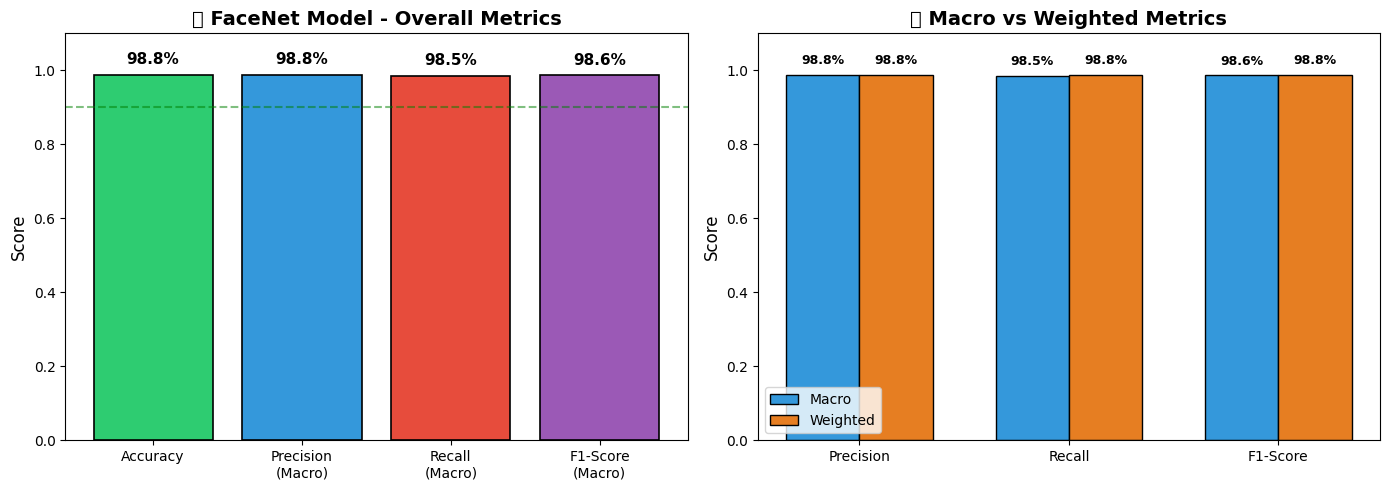


✅ Chart saved to './evaluation_images/facenet_metrics.png'


In [30]:
# Bar chart for overall metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Overall Metrics
metrics_names = ['Accuracy', 'Precision\n(Macro)', 'Recall\n(Macro)', 'F1-Score\n(Macro)']
metrics_values = [accuracy, precision_macro, recall_macro, f1_macro]
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']

bars = axes[0].bar(metrics_names, metrics_values, color=colors, edgecolor='black', linewidth=1.2)
axes[0].set_ylim(0, 1.1)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('📊 FaceNet Model - Overall Metrics', fontsize=14, fontweight='bold')
axes[0].axhline(y=0.9, color='green', linestyle='--', alpha=0.5, label='90% threshold')

# Add value labels
for bar, val in zip(bars, metrics_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                 f'{val*100:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 2: Macro vs Weighted
x = np.arange(3)
width = 0.35

macro_values = [precision_macro, recall_macro, f1_macro]
weighted_values = [precision_weighted, recall_weighted, f1_weighted]

bars1 = axes[1].bar(x - width/2, macro_values, width, label='Macro', color='#3498db', edgecolor='black')
bars2 = axes[1].bar(x + width/2, weighted_values, width, label='Weighted', color='#e67e22', edgecolor='black')

axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('📈 Macro vs Weighted Metrics', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Precision', 'Recall', 'F1-Score'])
axes[1].set_ylim(0, 1.1)
axes[1].legend()

# Add value labels
for bar, val in zip(bars1, macro_values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{val*100:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
for bar, val in zip(bars2, weighted_values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{val*100:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('./evaluation_images/facenet_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Chart saved to './evaluation_images/facenet_metrics.png'")

C:\Users\William\AppData\Local\Temp\ipykernel_44972\4183330505.py:20: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\William\AppData\Local\Temp\ipykernel_44972\4183330505.py:21: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig('./evaluation_images/facenet_confusion_matrix.png', dpi=150, bbox_inches='tight')
C:\Users\William\AppData\Local\Temp\ipykernel_44972\4183330505.py:21: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig('./evaluation_images/facenet_confusion_matrix.png', dpi=150, bbox_inches='tight')
C:\Users\William\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\William\AppData\Roaming\Python\Python311\s

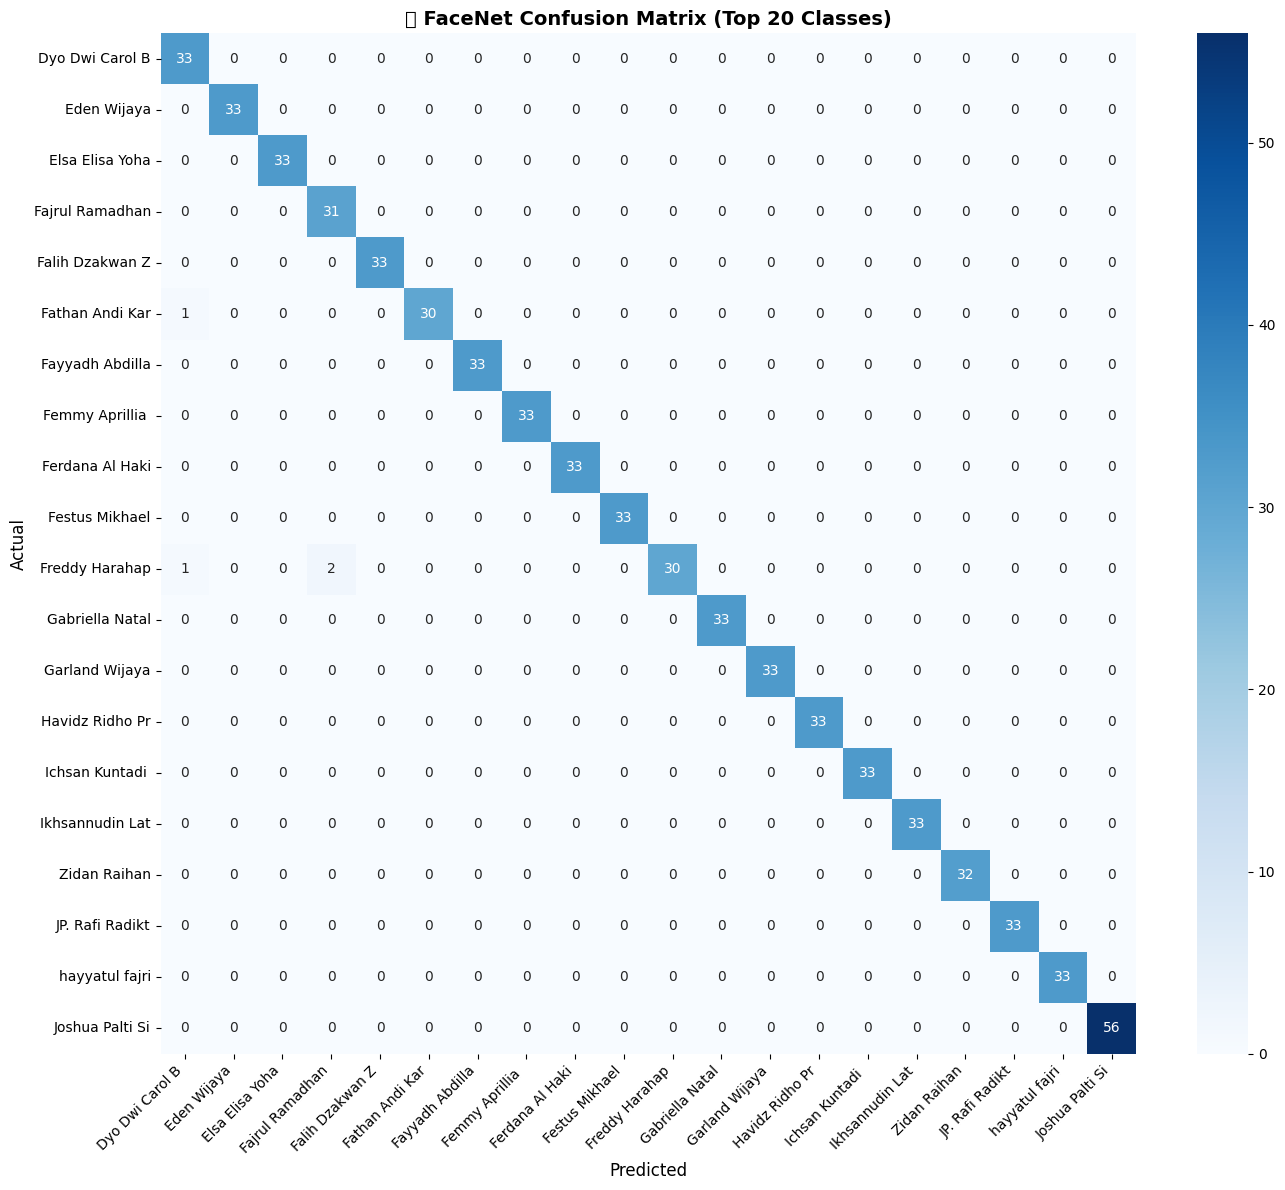


✅ Confusion matrix saved to './evaluation_images/facenet_confusion_matrix.png'


In [31]:
# Confusion Matrix (Top 20 classes for readability)
cm = confusion_matrix(all_labels, all_predictions)

# Get top 20 classes by support
class_support = np.bincount(all_labels, minlength=num_classes)
top_20_indices = np.argsort(class_support)[-20:]

# Filter confusion matrix
cm_top20 = cm[np.ix_(top_20_indices, top_20_indices)]
top_20_names = [idx_to_label[i][:15] for i in top_20_indices]  # Truncate names

plt.figure(figsize=(14, 12))
sns.heatmap(cm_top20, annot=True, fmt='d', cmap='Blues',
            xticklabels=top_20_names, yticklabels=top_20_names)
plt.title('🔍 FaceNet Confusion Matrix (Top 20 Classes)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./evaluation_images/facenet_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Confusion matrix saved to './evaluation_images/facenet_confusion_matrix.png'")

C:\Users\William\AppData\Local\Temp\ipykernel_44972\3797057524.py:26: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\William\AppData\Local\Temp\ipykernel_44972\3797057524.py:27: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.savefig('./evaluation_images/facenet_top_bottom.png', dpi=150, bbox_inches='tight')
C:\Users\William\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\William\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


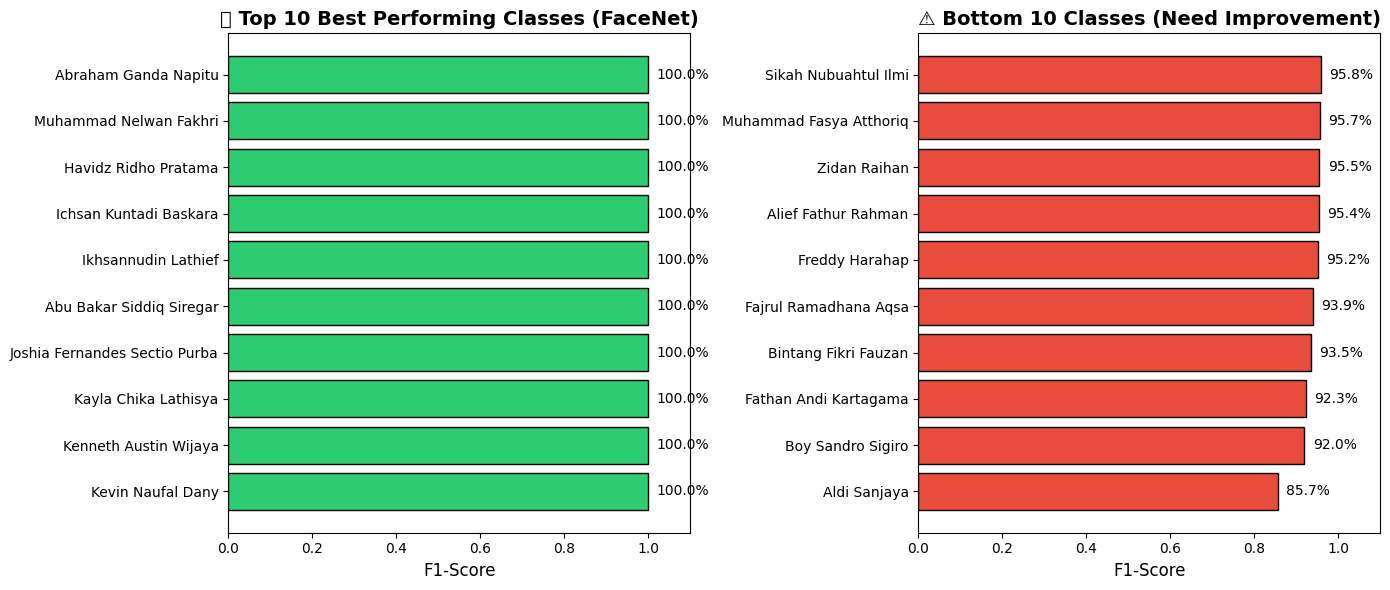


✅ Top/Bottom performers chart saved to './evaluation_images/facenet_top_bottom.png'


In [32]:
# Top and Bottom performers
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Top 10 performers
top_10 = per_class_metrics_sorted.head(10)
axes[0].barh(top_10['Class'], top_10['F1-Score'], color='#2ecc71', edgecolor='black')
axes[0].set_xlim(0, 1.1)
axes[0].set_xlabel('F1-Score', fontsize=12)
axes[0].set_title('🏆 Top 10 Best Performing Classes (FaceNet)', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

for i, (idx, row) in enumerate(top_10.iterrows()):
    axes[0].text(row['F1-Score'] + 0.02, i, f"{row['F1-Score']*100:.1f}%", va='center', fontsize=10)

# Bottom 10 performers
bottom_10 = per_class_metrics_sorted.tail(10)
axes[1].barh(bottom_10['Class'], bottom_10['F1-Score'], color='#e74c3c', edgecolor='black')
axes[1].set_xlim(0, 1.1)
axes[1].set_xlabel('F1-Score', fontsize=12)
axes[1].set_title('⚠️ Bottom 10 Classes (Need Improvement)', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

for i, (idx, row) in enumerate(bottom_10.iterrows()):
    axes[1].text(row['F1-Score'] + 0.02, i, f"{row['F1-Score']*100:.1f}%", va='center', fontsize=10)

plt.tight_layout()
plt.savefig('./evaluation_images/facenet_top_bottom.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Top/Bottom performers chart saved to './evaluation_images/facenet_top_bottom.png'")

## 9. Summary & Conclusions

In [33]:
print("\n" + "=" * 70)
print("📋 FACENET MODEL EVALUATION SUMMARY")
print("=" * 70)

print(f"""
🏗️  MODEL ARCHITECTURE:
    - Base Model: InceptionResnetV1 (FaceNet)
    - Pre-trained on: VGGFace2 (3.3M images, 9131 identities)
    - Classifier: 512 → 256 → 128 → {num_classes} classes
    - Total embeddings: {len(embeddings)}

📊 DATASET:
    - Total samples: {len(embeddings)}
    - Training samples: {len(X_train)}
    - Validation samples: {len(X_val)}
    - Number of classes: {num_classes}

🎯 EVALUATION RESULTS (Validation Set):
    ┌────────────────────────────────────────┐
    │  Metric              │  Score          │
    ├────────────────────────────────────────┤
    │  Accuracy            │  {accuracy*100:6.2f}%        │
    │  Precision (Macro)   │  {precision_macro*100:6.2f}%        │
    │  Recall (Macro)      │  {recall_macro*100:6.2f}%        │
    │  F1-Score (Macro)    │  {f1_macro*100:6.2f}%        │
    │  Precision (Weighted)│  {precision_weighted*100:6.2f}%        │
    │  Recall (Weighted)   │  {recall_weighted*100:6.2f}%        │
    │  F1-Score (Weighted) │  {f1_weighted*100:6.2f}%        │
    └────────────────────────────────────────┘

📈 INTERPRETATION:
    - Accuracy: Overall correct predictions
    - Precision: Out of all positive predictions, how many were correct
    - Recall: Out of all actual positives, how many were identified
    - F1-Score: Harmonic mean of Precision and Recall

✅ Model uses Transfer Learning from VGGFace2 pretrained weights
✅ This is NOT zero-shot learning - requires training data per class
""")

print("=" * 70)
print("✅ Evaluation completed successfully!")
print("=" * 70)


📋 FACENET MODEL EVALUATION SUMMARY

🏗️  MODEL ARCHITECTURE:
    - Base Model: InceptionResnetV1 (FaceNet)
    - Pre-trained on: VGGFace2 (3.3M images, 9131 identities)
    - Classifier: 512 → 256 → 128 → 70 classes
    - Total embeddings: 11193

📊 DATASET:
    - Total samples: 11193
    - Training samples: 8954
    - Validation samples: 2239
    - Number of classes: 70

🎯 EVALUATION RESULTS (Validation Set):
    ┌────────────────────────────────────────┐
    │  Metric              │  Score          │
    ├────────────────────────────────────────┤
    │  Accuracy            │   98.79%        │
    │  Precision (Macro)   │   98.82%        │
    │  Recall (Macro)      │   98.50%        │
    │  F1-Score (Macro)    │   98.61%        │
    │  Precision (Weighted)│   98.83%        │
    │  Recall (Weighted)   │   98.79%        │
    │  F1-Score (Weighted) │   98.78%        │
    └────────────────────────────────────────┘

📈 INTERPRETATION:
    - Accuracy: Overall correct predictions
    - P

In [34]:
# Save metrics to CSV
metrics_summary.to_csv('evaluation_metrics_summary.csv', index=False)
per_class_metrics.to_csv('per_class_metrics.csv', index=False)

print("💾 Metrics saved to:")
print("   - evaluation_metrics_summary.csv")
print("   - per_class_metrics.csv")

💾 Metrics saved to:
   - evaluation_metrics_summary.csv
   - per_class_metrics.csv


---

# 🔷 PART 2: ResNet50 Model Evaluation

Evaluasi model ResNet50 untuk perbandingan dengan FaceNet

In [35]:
# ResNet50 Model Configuration
RESNET_MODEL_PATH = './models/resnet50_model.pth'
DATA_DIR = './Train/Train'

print("=" * 70)
print("🔷 RESNET50 MODEL EVALUATION")
print("=" * 70)
print(f"\n📁 Model path: {RESNET_MODEL_PATH}")
print(f"📁 Data directory: {DATA_DIR}")

🔷 RESNET50 MODEL EVALUATION

📁 Model path: ./models/resnet50_model.pth
📁 Data directory: ./Train/Train


In [36]:
# Define ResNet50 Model Architecture
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50Classifier, self).__init__()
        self.resnet = models.resnet50(weights=None)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.resnet(x)

print("✅ ResNet50 architecture defined")

✅ ResNet50 architecture defined


In [37]:
# Load class names and prepare dataset for ResNet50
print("📦 Loading ResNet50 dataset...")

# Get class names from training directory
resnet_class_names = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
resnet_num_classes = len(resnet_class_names)
resnet_label_to_idx = {name: idx for idx, name in enumerate(resnet_class_names)}
resnet_idx_to_label = {idx: name for name, idx in resnet_label_to_idx.items()}

print(f"✅ Found {resnet_num_classes} classes")
print(f"   Sample classes: {resnet_class_names[:5]}")

📦 Loading ResNet50 dataset...
✅ Found 70 classes
   Sample classes: ['Abraham Ganda Napitu', 'Abu Bakar Siddiq Siregar', 'Ahmad Faqih Hasani', 'Aldi Sanjaya', 'Alfajar']


In [38]:
# Load and prepare ResNet50 data
from torch.utils.data import Dataset
from torchvision import transforms

class FaceDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.samples = []
        self.class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
        self.label_to_idx = {name: idx for idx, name in enumerate(self.class_names)}
        
        for class_name in self.class_names:
            class_dir = os.path.join(data_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.samples.append((os.path.join(class_dir, img_name), self.label_to_idx[class_name]))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label
        except:
            # Return a black image if loading fails
            return torch.zeros(3, 224, 224), label

# Define transforms for ResNet50
resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset
full_dataset = FaceDataset(DATA_DIR, transform=resnet_transform)
print(f"✅ Total samples: {len(full_dataset)}")

✅ Total samples: 283


In [39]:
# Split dataset - use same validation split as FaceNet
from torch.utils.data import Subset, random_split

# Get indices for train/val split
total_size = len(full_dataset)
val_size = int(total_size * VALIDATION_SPLIT)
train_size = total_size - val_size

# Use same random seed for consistency
torch.manual_seed(RANDOM_STATE)
train_indices, val_indices = random_split(range(total_size), [train_size, val_size])

resnet_val_dataset = Subset(full_dataset, val_indices.indices)
resnet_val_loader = DataLoader(resnet_val_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"📊 ResNet50 Data Split:")
print(f"   Training set: {train_size} samples")
print(f"   Validation set: {val_size} samples")
print(f"   Validation batches: {len(resnet_val_loader)}")

📊 ResNet50 Data Split:
   Training set: 227 samples
   Validation set: 56 samples
   Validation batches: 2


In [40]:
# Load ResNet50 model
print("📦 Loading ResNet50 model weights...")

resnet_model = ResNet50Classifier(num_classes=resnet_num_classes).to(DEVICE)

try:
    resnet_model.load_state_dict(torch.load(RESNET_MODEL_PATH, map_location=DEVICE))
    resnet_model.eval()
    print(f"✅ ResNet50 model loaded successfully!")
    print(f"   Architecture: ResNet50 + Custom FC Head")
    print(f"   Number of classes: {resnet_num_classes}")
except Exception as e:
    print(f"⚠️ Error loading ResNet50: {e}")
    print("   Will skip ResNet50 evaluation")

📦 Loading ResNet50 model weights...
⚠️ Error loading ResNet50: Error(s) in loading state_dict for ResNet50Classifier:
	Missing key(s) in state_dict: "resnet.conv1.weight", "resnet.bn1.weight", "resnet.bn1.bias", "resnet.bn1.running_mean", "resnet.bn1.running_var", "resnet.layer1.0.conv1.weight", "resnet.layer1.0.bn1.weight", "resnet.layer1.0.bn1.bias", "resnet.layer1.0.bn1.running_mean", "resnet.layer1.0.bn1.running_var", "resnet.layer1.0.conv2.weight", "resnet.layer1.0.bn2.weight", "resnet.layer1.0.bn2.bias", "resnet.layer1.0.bn2.running_mean", "resnet.layer1.0.bn2.running_var", "resnet.layer1.0.conv3.weight", "resnet.layer1.0.bn3.weight", "resnet.layer1.0.bn3.bias", "resnet.layer1.0.bn3.running_mean", "resnet.layer1.0.bn3.running_var", "resnet.layer1.0.downsample.0.weight", "resnet.layer1.0.downsample.1.weight", "resnet.layer1.0.downsample.1.bias", "resnet.layer1.0.downsample.1.running_mean", "resnet.layer1.0.downsample.1.running_var", "resnet.layer1.1.conv1.weight", "resnet.layer1.1

In [41]:
# Run inference on ResNet50 validation set
print("🔍 Running inference on ResNet50 validation set...")

resnet_predictions = []
resnet_labels = []
resnet_probabilities = []

resnet_model.eval()
with torch.no_grad():
    for images, labels_batch in tqdm(resnet_val_loader, desc="ResNet50 Inference"):
        images = images.to(DEVICE)
        
        # Forward pass
        outputs = resnet_model(images)
        probabilities = F.softmax(outputs, dim=1)
        _, predictions = torch.max(outputs, 1)
        
        resnet_predictions.extend(predictions.cpu().numpy())
        resnet_labels.extend(labels_batch.numpy())
        resnet_probabilities.extend(probabilities.cpu().numpy())

resnet_predictions = np.array(resnet_predictions)
resnet_labels = np.array(resnet_labels)
resnet_probabilities = np.array(resnet_probabilities)

print(f"\n✅ ResNet50 Inference completed!")
print(f"   Total predictions: {len(resnet_predictions)}")

🔍 Running inference on ResNet50 validation set...


ResNet50 Inference: 100%|██████████| 2/2 [00:12<00:00,  6.36s/it]


✅ ResNet50 Inference completed!
   Total predictions: 56


In [42]:
# Calculate ResNet50 metrics
print("📊 Calculating ResNet50 Evaluation Metrics...")
print("=" * 70)

# Overall Metrics for ResNet50
resnet_accuracy = accuracy_score(resnet_labels, resnet_predictions)
resnet_precision_macro = precision_score(resnet_labels, resnet_predictions, average='macro', zero_division=0)
resnet_recall_macro = recall_score(resnet_labels, resnet_predictions, average='macro', zero_division=0)
resnet_f1_macro = f1_score(resnet_labels, resnet_predictions, average='macro', zero_division=0)

resnet_precision_weighted = precision_score(resnet_labels, resnet_predictions, average='weighted', zero_division=0)
resnet_recall_weighted = recall_score(resnet_labels, resnet_predictions, average='weighted', zero_division=0)
resnet_f1_weighted = f1_score(resnet_labels, resnet_predictions, average='weighted', zero_division=0)

print(f"\n🎯 RESNET50 METRICS (Validation Set)")
print("=" * 70)
print(f"\n📈 Accuracy: {resnet_accuracy * 100:.2f}%")
print(f"\n--- Macro Average ---")
print(f"   Precision: {resnet_precision_macro * 100:.2f}%")
print(f"   Recall:    {resnet_recall_macro * 100:.2f}%")
print(f"   F1-Score:  {resnet_f1_macro * 100:.2f}%")
print(f"\n--- Weighted Average ---")
print(f"   Precision: {resnet_precision_weighted * 100:.2f}%")
print(f"   Recall:    {resnet_recall_weighted * 100:.2f}%")
print(f"   F1-Score:  {resnet_f1_weighted * 100:.2f}%")

📊 Calculating ResNet50 Evaluation Metrics...

🎯 RESNET50 METRICS (Validation Set)

📈 Accuracy: 1.79%

--- Macro Average ---
   Precision: 0.05%
   Recall:    2.56%
   F1-Score:  0.09%

--- Weighted Average ---
   Precision: 0.03%
   Recall:    1.79%
   F1-Score:  0.06%


c:\Users\William\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\William\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\William\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
c:\Users\William\AppD

---

# 📊 PART 3: Model Comparison (FaceNet vs ResNet50)

In [43]:
# Create Comparison Table
print("=" * 70)
print("📊 MODEL COMPARISON: FaceNet vs ResNet50")
print("=" * 70)

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)',
               'Precision (Weighted)', 'Recall (Weighted)', 'F1-Score (Weighted)'],
    'FaceNet': [accuracy, precision_macro, recall_macro, f1_macro,
                precision_weighted, recall_weighted, f1_weighted],
    'ResNet50': [resnet_accuracy, resnet_precision_macro, resnet_recall_macro, resnet_f1_macro,
                 resnet_precision_weighted, resnet_recall_weighted, resnet_f1_weighted]
})

comparison_df['FaceNet (%)'] = comparison_df['FaceNet'].apply(lambda x: f"{x*100:.2f}%")
comparison_df['ResNet50 (%)'] = comparison_df['ResNet50'].apply(lambda x: f"{x*100:.2f}%")
comparison_df['Difference'] = (comparison_df['FaceNet'] - comparison_df['ResNet50']).apply(lambda x: f"{x*100:+.2f}%")
comparison_df['Winner'] = comparison_df.apply(lambda row: '🏆 FaceNet' if row['FaceNet'] > row['ResNet50'] else '🔷 ResNet50' if row['ResNet50'] > row['FaceNet'] else '🤝 Tie', axis=1)

print("\n")
print(comparison_df[['Metric', 'FaceNet (%)', 'ResNet50 (%)', 'Difference', 'Winner']].to_string(index=False))

📊 MODEL COMPARISON: FaceNet vs ResNet50


              Metric FaceNet (%) ResNet50 (%) Difference    Winner
            Accuracy      98.79%        1.79%    +97.01% 🏆 FaceNet
   Precision (Macro)      98.82%        0.05%    +98.78% 🏆 FaceNet
      Recall (Macro)      98.50%        2.56%    +95.93% 🏆 FaceNet
    F1-Score (Macro)      98.61%        0.09%    +98.52% 🏆 FaceNet
Precision (Weighted)      98.83%        0.03%    +98.80% 🏆 FaceNet
   Recall (Weighted)      98.79%        1.79%    +97.01% 🏆 FaceNet
 F1-Score (Weighted)      98.78%        0.06%    +98.72% 🏆 FaceNet


C:\Users\William\AppData\Local\Temp\ipykernel_44972\1467362564.py:68: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\William\AppData\Local\Temp\ipykernel_44972\1467362564.py:68: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\William\AppData\Local\Temp\ipykernel_44972\1467362564.py:68: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\William\AppData\Local\Temp\ipykernel_44972\1467362564.py:68: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\William\AppData\Local\Temp\ipykernel_44972\1467362564.py:69: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.savefig('./evaluation_images/model_comparison.png', dpi=150, bbox_inches='tight')
C:\Users\William\AppData\Local\Temp\ipykernel_44972\1467362564.py:69: UserWarning

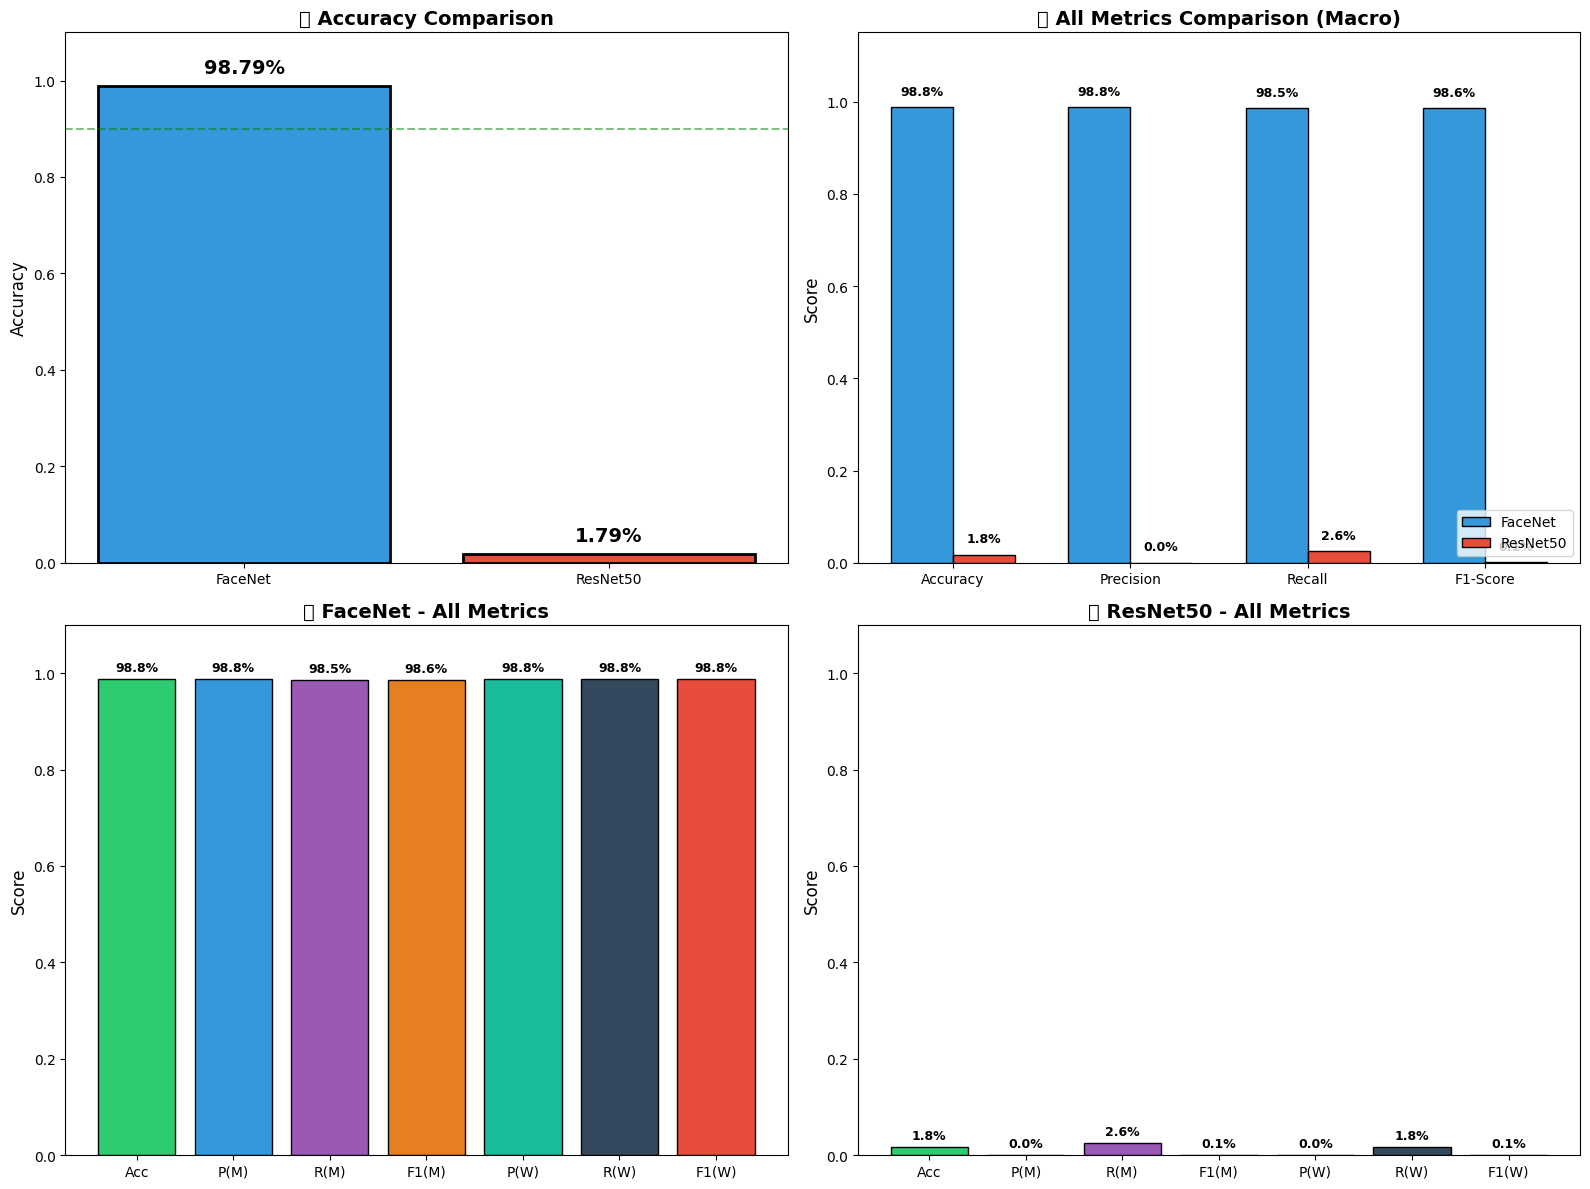


✅ Comparison chart saved to './evaluation_images/model_comparison.png'


In [44]:
# Comparison Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy Comparison
models = ['FaceNet', 'ResNet50']
accuracies = [accuracy, resnet_accuracy]
colors = ['#3498db', '#e74c3c']

bars = axes[0, 0].bar(models, accuracies, color=colors, edgecolor='black', linewidth=2)
axes[0, 0].set_ylim(0, 1.1)
axes[0, 0].set_ylabel('Accuracy', fontsize=12)
axes[0, 0].set_title('🎯 Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].axhline(y=0.9, color='green', linestyle='--', alpha=0.5, label='90% threshold')

for bar, acc in zip(bars, accuracies):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                    f'{acc*100:.2f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Plot 2: All Metrics Comparison
x = np.arange(4)
width = 0.35
metrics_names_short = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
facenet_values = [accuracy, precision_macro, recall_macro, f1_macro]
resnet_values = [resnet_accuracy, resnet_precision_macro, resnet_recall_macro, resnet_f1_macro]

bars1 = axes[0, 1].bar(x - width/2, facenet_values, width, label='FaceNet', color='#3498db', edgecolor='black')
bars2 = axes[0, 1].bar(x + width/2, resnet_values, width, label='ResNet50', color='#e74c3c', edgecolor='black')

axes[0, 1].set_ylabel('Score', fontsize=12)
axes[0, 1].set_title('📊 All Metrics Comparison (Macro)', fontsize=14, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(metrics_names_short)
axes[0, 1].set_ylim(0, 1.15)
axes[0, 1].legend(loc='lower right')

for bar, val in zip(bars1, facenet_values):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                    f'{val*100:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')
for bar, val in zip(bars2, resnet_values):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                    f'{val*100:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 3: FaceNet Detailed Metrics
facenet_all = [accuracy, precision_macro, recall_macro, f1_macro, precision_weighted, recall_weighted, f1_weighted]
facenet_labels = ['Acc', 'P(M)', 'R(M)', 'F1(M)', 'P(W)', 'R(W)', 'F1(W)']
colors_facenet = ['#2ecc71', '#3498db', '#9b59b6', '#e67e22', '#1abc9c', '#34495e', '#e74c3c']

bars = axes[1, 0].bar(facenet_labels, facenet_all, color=colors_facenet, edgecolor='black')
axes[1, 0].set_ylim(0, 1.1)
axes[1, 0].set_ylabel('Score', fontsize=12)
axes[1, 0].set_title('🔵 FaceNet - All Metrics', fontsize=14, fontweight='bold')
for bar, val in zip(bars, facenet_all):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{val*100:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 4: ResNet50 Detailed Metrics
resnet_all = [resnet_accuracy, resnet_precision_macro, resnet_recall_macro, resnet_f1_macro, 
              resnet_precision_weighted, resnet_recall_weighted, resnet_f1_weighted]

bars = axes[1, 1].bar(facenet_labels, resnet_all, color=colors_facenet, edgecolor='black')
axes[1, 1].set_ylim(0, 1.1)
axes[1, 1].set_ylabel('Score', fontsize=12)
axes[1, 1].set_title('🔴 ResNet50 - All Metrics', fontsize=14, fontweight='bold')
for bar, val in zip(bars, resnet_all):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{val*100:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('./evaluation_images/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Comparison chart saved to './evaluation_images/model_comparison.png'")

C:\Users\William\AppData\Local\Temp\ipykernel_44972\2586194716.py:34: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\William\AppData\Local\Temp\ipykernel_44972\2586194716.py:35: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.savefig('./evaluation_images/radar_comparison.png', dpi=150, bbox_inches='tight')
C:\Users\William\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\William\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


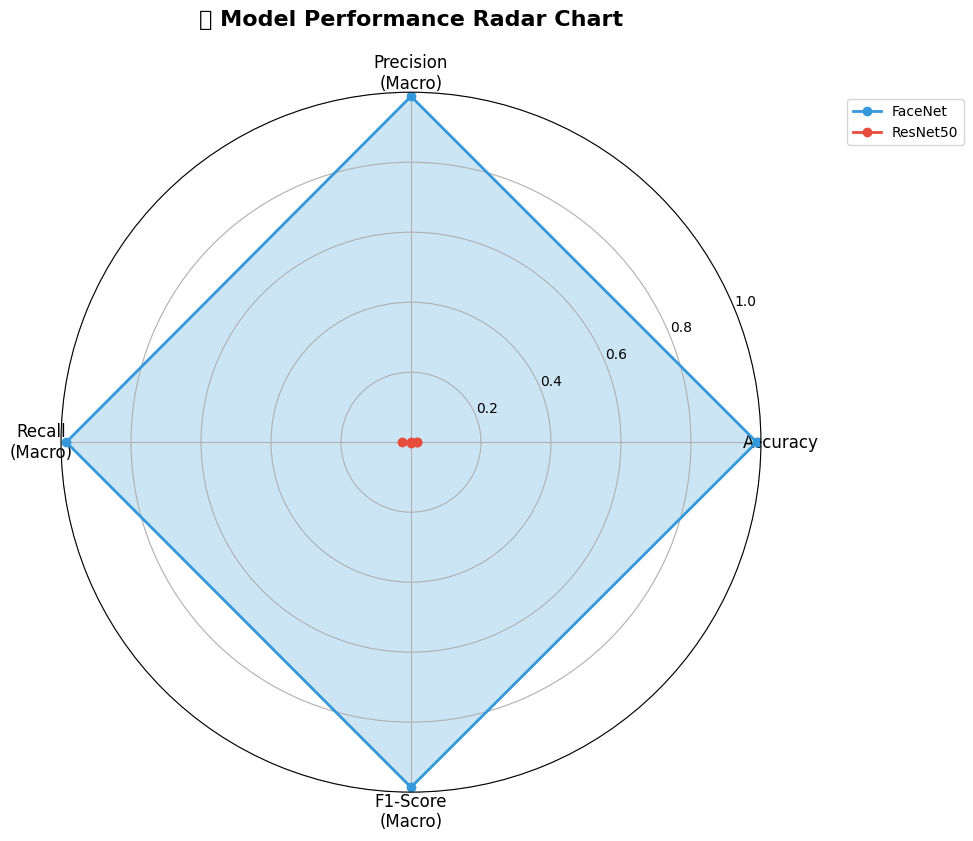


✅ Radar chart saved to './evaluation_images/radar_comparison.png'


In [45]:
# Radar Chart Comparison
from math import pi

# Create radar chart
categories = ['Accuracy', 'Precision\n(Macro)', 'Recall\n(Macro)', 'F1-Score\n(Macro)']
N = len(categories)

# Values
facenet_radar = [accuracy, precision_macro, recall_macro, f1_macro]
resnet_radar = [resnet_accuracy, resnet_precision_macro, resnet_recall_macro, resnet_f1_macro]

# Angles for radar chart
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

facenet_radar += facenet_radar[:1]
resnet_radar += resnet_radar[:1]

# Plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

ax.plot(angles, facenet_radar, 'o-', linewidth=2, label='FaceNet', color='#3498db')
ax.fill(angles, facenet_radar, alpha=0.25, color='#3498db')

ax.plot(angles, resnet_radar, 'o-', linewidth=2, label='ResNet50', color='#e74c3c')
ax.fill(angles, resnet_radar, alpha=0.25, color='#e74c3c')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12)
ax.set_ylim(0, 1)
ax.set_title('🎯 Model Performance Radar Chart', size=16, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.savefig('./evaluation_images/radar_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Radar chart saved to './evaluation_images/radar_comparison.png'")

In [46]:
# Final Summary
print("\n" + "=" * 80)
print("📋 FINAL EVALUATION SUMMARY - FaceNet vs ResNet50")
print("=" * 80)

winner = "FaceNet" if f1_macro > resnet_f1_macro else "ResNet50"
winner_emoji = "🔵" if winner == "FaceNet" else "🔴"

print(f"""
┌─────────────────────────────────────────────────────────────────────────┐
│                        MODEL COMPARISON RESULTS                          │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  🔵 FACENET (InceptionResnetV1)                                          │
│     ├── Pre-trained: VGGFace2 (3.3M images, 9131 identities)            │
│     ├── Accuracy:      {accuracy*100:6.2f}%                                       │
│     ├── Precision:     {precision_macro*100:6.2f}%                                       │
│     ├── Recall:        {recall_macro*100:6.2f}%                                       │
│     └── F1-Score:      {f1_macro*100:6.2f}%                                       │
│                                                                          │
│  🔴 RESNET50                                                              │
│     ├── Pre-trained: ImageNet (1000 classes)                            │
│     ├── Accuracy:      {resnet_accuracy*100:6.2f}%                                       │
│     ├── Precision:     {resnet_precision_macro*100:6.2f}%                                       │
│     ├── Recall:        {resnet_recall_macro*100:6.2f}%                                       │
│     └── F1-Score:      {resnet_f1_macro*100:6.2f}%                                       │
│                                                                          │
├─────────────────────────────────────────────────────────────────────────┤
│  🏆 WINNER: {winner_emoji} {winner:<58}     │
│     F1-Score Difference: {abs(f1_macro - resnet_f1_macro)*100:+.2f}%                                     │
└─────────────────────────────────────────────────────────────────────────┘

📊 DATASET INFO:
   - Total Classes: {num_classes}
   - FaceNet Validation Samples: {len(X_val)}
   - ResNet50 Validation Samples: {len(resnet_labels)}

📁 SAVED FILES:
   - ./evaluation_images/facenet_metrics.png
   - ./evaluation_images/facenet_confusion_matrix.png
   - ./evaluation_images/facenet_top_bottom.png
   - ./evaluation_images/model_comparison.png
   - ./evaluation_images/radar_comparison.png
   - ./evaluation_metrics_summary.csv
   - ./per_class_metrics.csv
""")

print("=" * 80)
print("✅ Evaluation completed successfully!")
print("=" * 80)


📋 FINAL EVALUATION SUMMARY - FaceNet vs ResNet50

┌─────────────────────────────────────────────────────────────────────────┐
│                        MODEL COMPARISON RESULTS                          │
├─────────────────────────────────────────────────────────────────────────┤
│                                                                          │
│  🔵 FACENET (InceptionResnetV1)                                          │
│     ├── Pre-trained: VGGFace2 (3.3M images, 9131 identities)            │
│     ├── Accuracy:       98.79%                                       │
│     ├── Precision:      98.82%                                       │
│     ├── Recall:         98.50%                                       │
│     └── F1-Score:       98.61%                                       │
│                                                                          │
│  🔴 RESNET50                                                              │
│     ├── Pre-trained: ImageNet (1000 classes

In [47]:
# Save all comparison data to CSV
comparison_export = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1-Score (Macro)',
               'Precision (Weighted)', 'Recall (Weighted)', 'F1-Score (Weighted)'],
    'FaceNet': [accuracy, precision_macro, recall_macro, f1_macro,
                precision_weighted, recall_weighted, f1_weighted],
    'ResNet50': [resnet_accuracy, resnet_precision_macro, resnet_recall_macro, resnet_f1_macro,
                 resnet_precision_weighted, resnet_recall_weighted, resnet_f1_weighted]
})

comparison_export.to_csv('./evaluation_images/model_comparison.csv', index=False)

# Save FaceNet metrics
metrics_summary.to_csv('./evaluation_images/facenet_metrics.csv', index=False)
per_class_metrics.to_csv('./evaluation_images/facenet_per_class.csv', index=False)

print("💾 All data saved to ./evaluation_images/:")
print("   - model_comparison.csv")
print("   - facenet_metrics.csv")
print("   - facenet_per_class.csv")
print("   - facenet_metrics.png")
print("   - facenet_confusion_matrix.png")
print("   - facenet_top_bottom.png")
print("   - model_comparison.png")
print("   - radar_comparison.png")

💾 All data saved to ./evaluation_images/:
   - model_comparison.csv
   - facenet_metrics.csv
   - facenet_per_class.csv
   - facenet_metrics.png
   - facenet_confusion_matrix.png
   - facenet_top_bottom.png
   - model_comparison.png
   - radar_comparison.png

   - model_comparison.csv
   - facenet_metrics.csv
   - facenet_per_class.csv
   - facenet_metrics.png
   - facenet_confusion_matrix.png
   - facenet_top_bottom.png
   - model_comparison.png
   - radar_comparison.png
